In [ ]:
import numpy as np
import cv2, math
from skimage.util import random_noise
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (12, 8)

## 1) Image noise and de-noising: In this exercise we’ll look at various kinds of image noises and compare de-noising methods. Download the image ‘checkerboard.png’.

In [ ]:
!rm *.zip
!gdown 1D7GEijNrNOIsIKsh8CerDxr8zIeRsYH7
!unzip Assignment6.zip

# https://drive.google.com/file/d/1D7GEijNrNOIsIKsh8CerDxr8zIeRsYH7/view?usp=sharing
# https://drive.google.com/drive/folders/1tZfZGSGfoBoXw2U6PD-AWczrVgGxj6Oj?usp=share_link

Downloading...
From: https://drive.google.com/uc?id=1D7GEijNrNOIsIKsh8CerDxr8zIeRsYH7
To: /content/Assignment6.zip
100% 25.3M/25.3M [00:00<00:00, 157MB/s]
Archive:  Assignment6.zip
replace Assignment6/bookpage.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: Assignment6/bookpage.jpg  
  inflating: Assignment6/building.jpg  
  inflating: Assignment6/CalvinandHobbes/image1.jpg  
  inflating: Assignment6/CalvinandHobbes/image2.jpg  
  inflating: Assignment6/CalvinandHobbes/image3.jpg  
  inflating: Assignment6/checkerboard.png  
  inflating: Assignment6/CinqueTerre.jpg  
  inflating: Assignment6/Colors.png  
  inflating: Assignment6/Crop images - for extra credit problem/Feb_18_Window_1_102.tif  
  inflating: Assignment6/Crop images - for extra credit problem/Jan_22_Entry_2.tif  
  inflating: Assignment6/Crop images - for extra credit problem/Jan_29_Window1_102.tif  
  inflating: Assignment6/DeepLearningVs.TraditionalCV.pdf  
  inflating: Assignment6/Filtering/cameraman.jpg  
  i

### a) Adding noise: Add the following kinds of noise to the image either by image addition or by using the OpenCV function for
### i) Gaussian noise
### ii) Salt-and-pepper noise
### iii) periodic noise

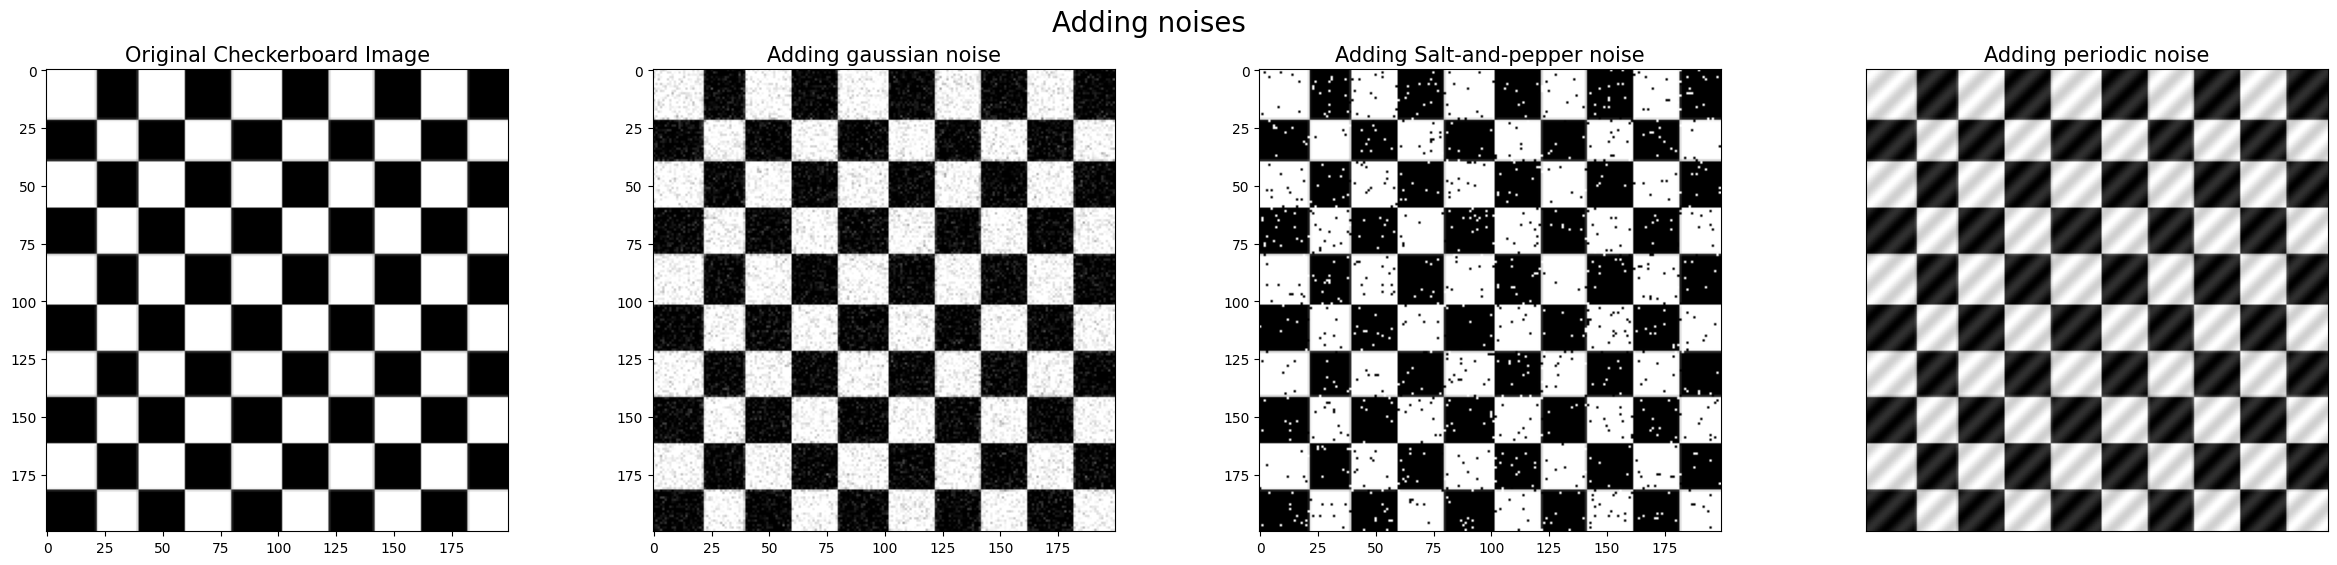

In [ ]:
img = cv2.imread('Assignment6/checkerboard.png',0)

# Adding different noises

# Adding gaussian noise
gauss_img = random_noise(img, mode = 'gaussian')* 255.0
gauss_img = gauss_img.astype(np.uint8)

# Adding Salt-and-pepper noise
salt_img = random_noise(img, mode = 's&p')* 255.0
salt_img = salt_img.astype(np.uint8)

# Adding periodic noise
def period_noise(image):
  M, N = img.shape
  noise = np.zeros((M,N), dtype='float64')
  X, Y = np.meshgrid(range(0, M), range(0, N))
  noise += 30 * np.sin(2*np.pi/14*X + 2*np.pi/14*Y)
  periodic_noise = img + noise
  return np.float32(periodic_noise)

period_img = period_noise(img)

# Displaying results
fig, ax = plt.subplots(1,4,figsize=(30,6))
ax[0].imshow(img, cmap = 'gray')
ax[0].set_title('Original Checkerboard Image', fontsize = 15), plt.xticks([]), plt.yticks([])
ax[1].imshow(gauss_img, cmap = 'gray')
ax[1].set_title('Adding gaussian noise', fontsize = 15), plt.xticks([]), plt.yticks([])
ax[2].imshow(salt_img, cmap = 'gray')
ax[2].set_title('Adding Salt-and-pepper noise', fontsize = 15), plt.xticks([]), plt.yticks([])
ax[3].imshow(period_img, cmap = 'gray')
ax[3].set_title('Adding periodic noise', fontsize = 15), plt.xticks([]), plt.yticks([])
plt.suptitle('Adding noises',fontsize = 20)
plt.show()

### b) De-noising: de-noise the images obtained above. Experiment with various filters such as smoothing Gaussian filter, median filter and the notch filter (for periodic noise) to see what works best. You may try other filters too.

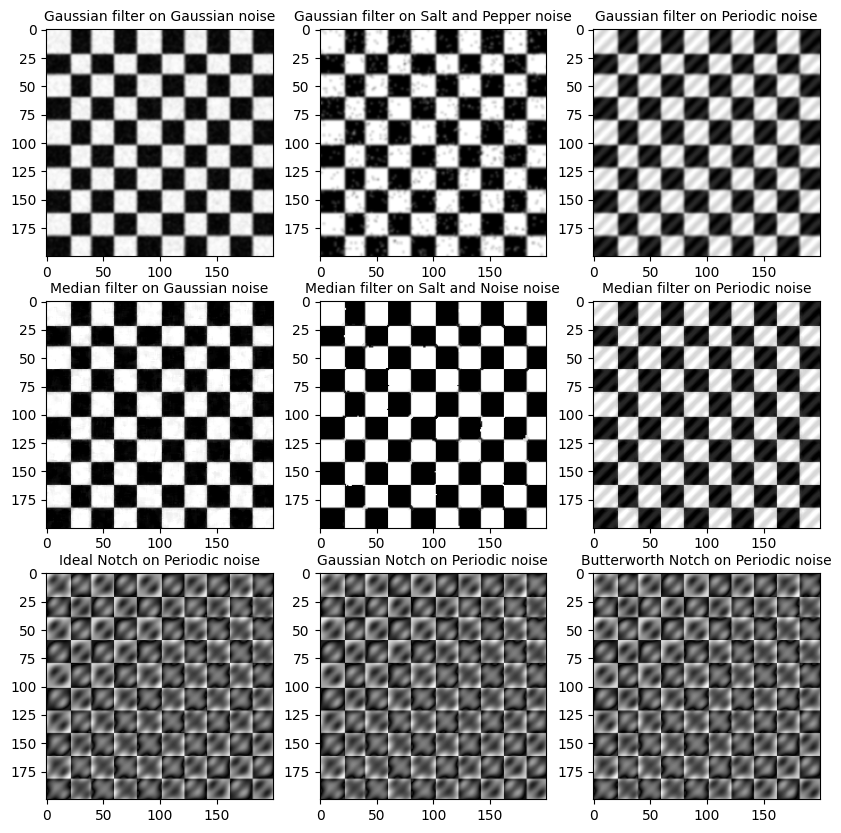

In [ ]:
# Functions for different types of notch filter:
def get_fshift_and_save_dft(img):
  img = np.asarray(img)
  f = np.fft.fft2(img)
  fshift = np.fft.fftshift(f)
  dft = 20 * np.log(np.abs(fshift))
  dft = cv2.dft(np.float32(img),flags = cv2.DFT_COMPLEX_OUTPUT)
  dft_shift = np.fft.fftshift(dft)

  magnitude_spectrum, phase_spectrum = cv2.cartToPolar(dft_shift[:,:,0],dft_shift[:,:,1])
  magnitude_spectrum_new = 20*np.log(1 + magnitude_spectrum)
  result = np.where(magnitude_spectrum_new == np.amax(magnitude_spectrum_new))
  result  = magnitude_spectrum_new.argsort(axis=-1, kind=None, order=None)[-9:][::-1]

  points =[]
  for i in range(9):
    highest, high_index = -1, 0.1
    for ind_i,i in enumerate(magnitude_spectrum_new):
      for ind_j,j in enumerate(i):
        if j>highest and not((ind_i, ind_j) in points):
          highest= j
          high_index=(ind_i, ind_j)
    points.append(high_index)

  return points[1:]

# Defining Notch Filters
def notch(img, filter):
  img = np.asarray(img)
  f = np.fft.fft2(img)
  fshift = np.fft.fftshift(f)
  dft, d0 = 20 * np.log(np.abs(fshift)), 0.5
  M, N  = fshift.shape

  points = get_fshift_and_save_dft(img.copy())
  for u in range(M):
    for v in range(N):
      for d in range(len(points)):
        u0, v0 = points[d][0], points[d][1]
        d1 = pow(pow(u - u0, 2) + pow(v - v0, 2), 1)
        d2 = pow(pow(u + u0, 2) + pow(v + v0, 2), 1)
        if filter == 'ideal-notch':
          if d1 <= d0 or d2 <= d0:
            fshift[u][v] *= 0.0
        elif filter == 'butter-notch':
          eps = 0.000001
          fshift[u][v] *= (1.0 / (1 + pow((d0 * d0) / (d1 * d2 + eps), 1)))
        elif filter == 'gaussian-notch':
          fshift[u][v] *= (1 - math.exp(-0.5 * (d1 * d2 / pow(d0, 2))))
  f_ishift = np.fft.ifftshift(fshift)
  return np.abs(np.fft.ifft2(f_ishift))



fig, ax = plt.subplots(3,3,figsize=(10,10))
ax[0,0].imshow(cv2.GaussianBlur(gauss_img, (5,5), 0), cmap = 'gray')
ax[0,0].set_title('Gaussian filter on Gaussian noise', fontsize = 10)
ax[0,1].imshow(cv2.GaussianBlur(salt_img, (5,5), 0), cmap = 'gray')
ax[0,1].set_title('Gaussian filter on Salt and Pepper noise', fontsize = 10)
ax[0,2].imshow(cv2.GaussianBlur(period_img, (5,5), 0), cmap = 'gray')
ax[0,2].set_title('Gaussian filter on Periodic noise', fontsize = 10)
ax[1,0].imshow(cv2.medianBlur(gauss_img, 5), cmap = 'gray')
ax[1,0].set_title('Median filter on Gaussian noise', fontsize = 10)
ax[1,1].imshow(cv2.medianBlur(salt_img, 5), cmap = 'gray')
ax[1,1].set_title('Median filter on Salt and Noise noise', fontsize = 10)
ax[1,2].imshow(cv2.medianBlur(period_img, 5), cmap = 'gray')
ax[1,2].set_title('Median filter on Periodic noise', fontsize = 10)
ax[2,0].imshow(notch(period_img,'ideal-notch'), cmap = 'gray')
ax[2,0].set_title('Ideal Notch on Periodic noise', fontsize = 10)
ax[2,1].imshow(notch(period_img,'gaussian-notch'), cmap = 'gray')
ax[2,1].set_title('Gaussian Notch on Periodic noise', fontsize = 10)
ax[2,2].imshow(notch(period_img,'butter-notch'), cmap = 'gray')
ax[2,2].set_title('Butterworth Notch on Periodic noise', fontsize = 10)
plt.show()

From the above images, we can draw the following conclusions:
* Median filter has been the most effective out of other filters for Salt and Pepper noise.
* Median filter has worked well for denoising Gaussian noise too (although the contrast of the image got reduced considerably).
* None of the methods work well in denoising periodic noise (median filter has worked comaratively better, but not satisfactorily).

Moreover, notch filters, which have been used exclusively to remove periodic noise, failed miserably in doing so.

### c) Apply the ideal, Gaussian and Butterworth notch filters on the images ‘notch1.jpg’, ‘notch2.png’ and ‘notch3.jpg’, and compare the results.

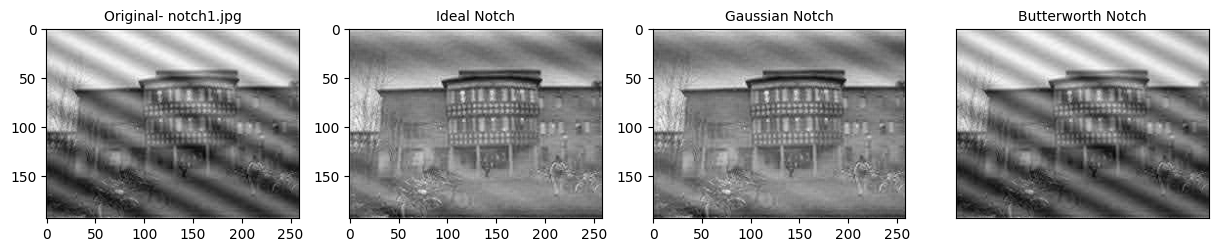

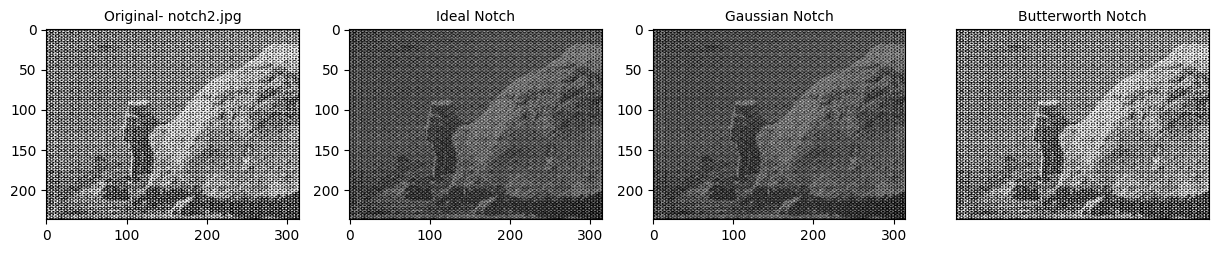

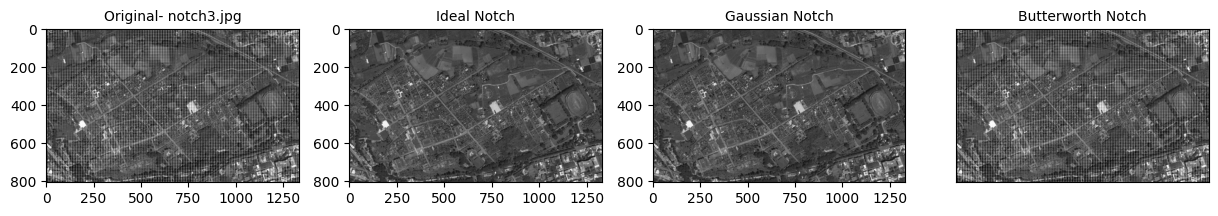

In [ ]:
im_list = [cv2.imread('Assignment6/notch1.jpg', 0), cv2.imread('Assignment6/notch2.png', 0),
           cv2.imread('Assignment6/notch3.jpg', 0)]

# Applying different filters
for i in range(3):
  fig, ax = plt.subplots(1,4,figsize=(15,6))
  ax[0].imshow(im_list[i], cmap = 'gray')
  ax[0].set_title(f'Original- notch{i+1}.jpg', fontsize = 10), plt.xticks([]), plt.yticks([])
  ax[1].imshow(notch(im_list[i], 'ideal-notch'), cmap = 'gray')
  ax[1].set_title('Ideal Notch', fontsize = 10), plt.xticks([]), plt.yticks([])
  ax[2].imshow(notch(im_list[i], 'gaussian-notch'), cmap = 'gray')
  ax[2].set_title('Gaussian Notch', fontsize = 10), plt.xticks([]), plt.yticks([])
  ax[3].imshow(notch(im_list[i], 'butterworth-notch'), cmap = 'gray')
  ax[3].set_title('Butterworth Notch', fontsize = 10), plt.xticks([]), plt.yticks([])
  plt.show()

From the above plots, we can say that the three notch filters (Ideal, Gaussian and Butterworth) has worked more or less same for each of the three images. It is also worthy to note that for the first two images, the filters are not working satisfactorily in removing the periodic noise; but, for the 3rd image ('notch3.jpg'), they work significantly good in cleaning the noise.

## 2) Thresholding comparisons: threshold the images ‘fingerprint1.jpg’, ‘fingerprint2.jpg’ and ‘bookpage.jpg’ using the first three methods. Display the histogram for each image and observe how the threshold is working each time. Say which method is giving you the best threshold in each case and why.


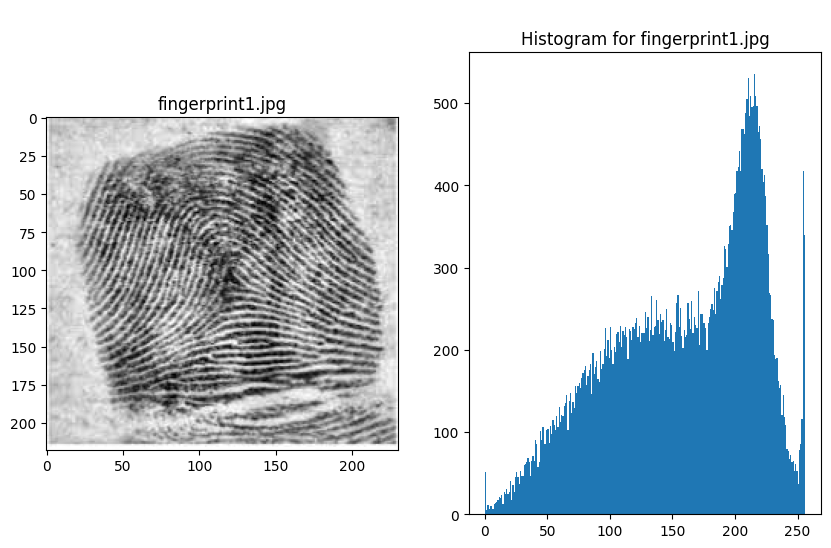

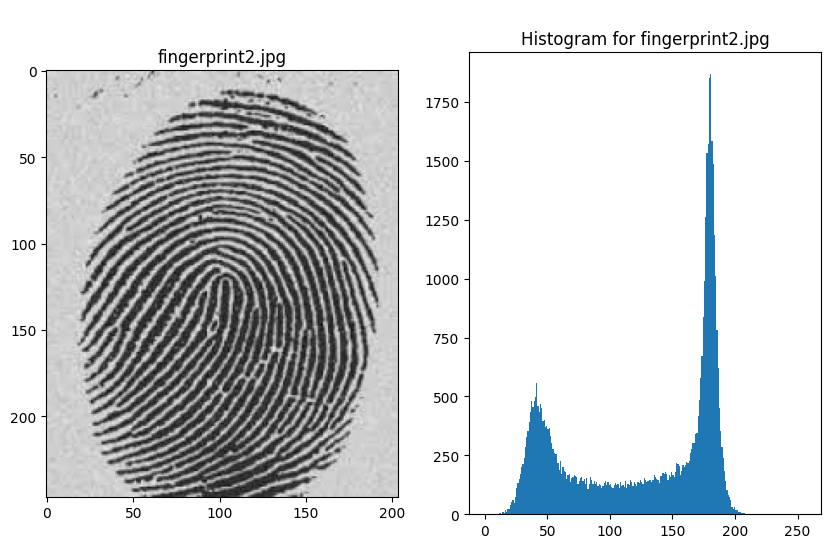

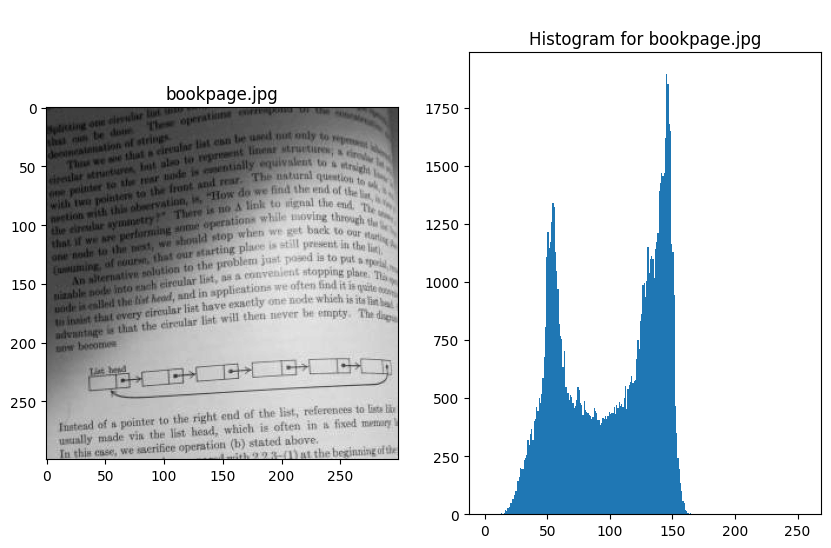

In [ ]:
finger_img1 = cv2.imread('Assignment6/fingerprint1.jpg', 0)
finger_img2 = cv2.imread('Assignment6/fingerprint2.jpg', 0)
book_img = cv2.imread('Assignment6/bookpage.jpg', 0)

im_list = [finger_img1, finger_img2, book_img]
names = ["fingerprint1.jpg","fingerprint2.jpg","bookpage.jpg"]

for i in range(3):
  fig, ax = plt.subplots(1,2,figsize=(10,6))
  ax[0].imshow(im_list[i], cmap = 'gray')
  ax[0].set_title(names[i])
  ax[1].hist(im_list[i].ravel(), 256, [0,256])
  ax[1].set_title(f"\nHistogram for {names[i]}")

### a) Manual thresholding - manually choose the threshold after observing the histogram.

From the above histograms, we can manually take the following thresholds for the images ‘fingerprint1.jpg’, ‘fingerprint2.jpg’ and ‘bookpage.jpg’ respectively: 150, 115, 100

In [ ]:
def man_threshold(img, threshold):
  row, column = img.shape
  img_new = np.zeros((row,column),dtype = 'uint8')
  for i in range(row):
    for j in range(column):
      if img[i,j] > threshold:
        img_new[i,j] = 255
      else:
        img_new[i,j] = 0
  return img_new

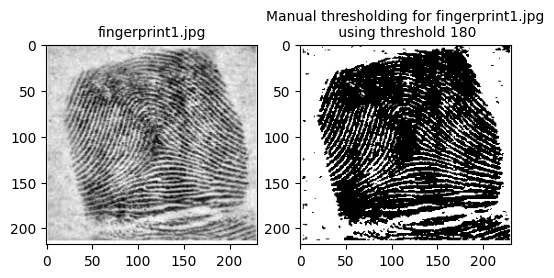

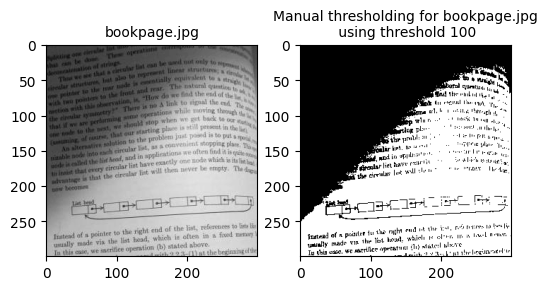

In [ ]:
th_list = [180,118,100]
for i in range(3):
  fig, ax = plt.subplots(1,2,figsize=(6,6))
  ax[0].imshow(im_list[i], cmap = 'gray')
  ax[0].set_title(names[i], fontsize = 10)
  ax[1].imshow(man_threshold(im_list[i],th_list[i]), cmap = 'gray')
  ax[1].set_title(f"Manual thresholding for {names[i]}\n using threshold {th_list[i]}", fontsize = 10)

### b) Global thresholding

In [ ]:
def global_threshold(img):
  th, dst = cv2.threshold(img, 127, 255, cv2.THRESH_BINARY);
  return dst

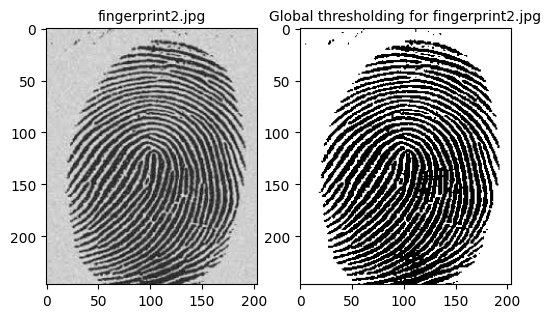

In [ ]:
for i in range(3):
  fig, ax = plt.subplots(1,2,figsize=(6,6))
  ax[0].imshow(im_list[i], cmap = 'gray')
  ax[0].set_title(names[i], fontsize = 10)
  ax[1].imshow(global_threshold(im_list[i]), cmap = 'gray')
  ax[1].set_title(f"Global thresholding for {names[i]}", fontsize = 10)

### c) Otsu’s method - measure the effectiveness of thresholding using the ratio of variances.

In [ ]:
def otsu_threshold(img):
  th, dst = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
  return dst

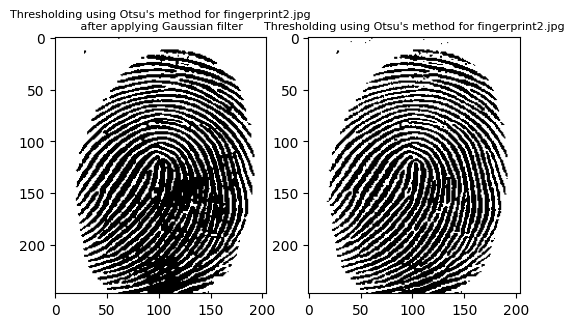

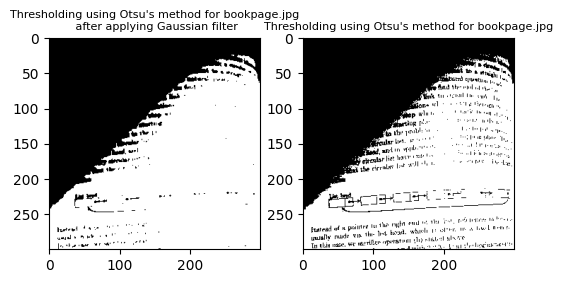

In [ ]:
for i in range(3):
  fig, ax = plt.subplots(1,2,figsize=(6,6))
  blur = cv2.GaussianBlur(im_list[i],(3,3),0)
  ax[0].imshow(otsu_threshold(blur), cmap = 'gray')
  ax[0].set_title(f"Thresholding using Otsu's method for {names[i]}\n after applying Gaussian filter", fontsize = 8)
  ax[1].imshow(otsu_threshold(im_list[i]), cmap = 'gray')
  ax[1].set_title(f"Thresholding using Otsu's method for {names[i]}", fontsize = 8)

From the above result we can say that applying Otsu's method on original image has worked better than applying the same on the Gaussian filtered image.

### d) Adaptive thresholding: try both mean and Gaussian.

In [ ]:
def adaptive_threshold(img):
  dst_m = cv2.adaptiveThreshold(im_list[i],255,cv2.ADAPTIVE_THRESH_MEAN_C,cv2.THRESH_BINARY,11,2)
  dst_g = cv2.adaptiveThreshold(im_list[i],255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY,11,2)
  return dst_m, dst_g

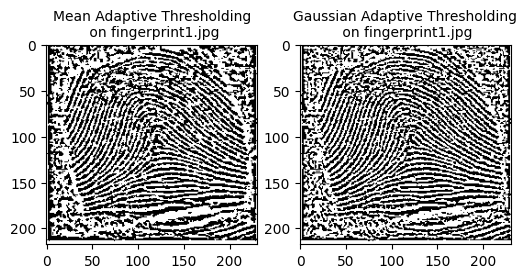

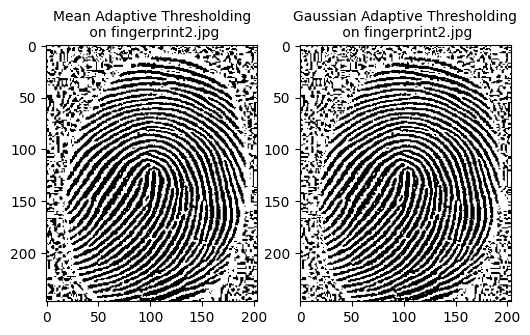

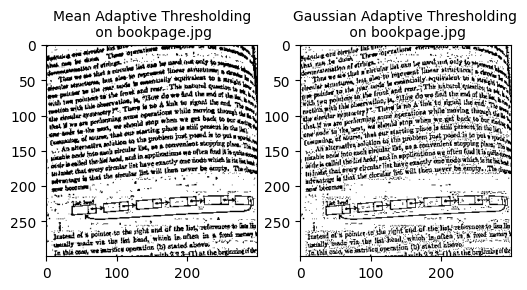

In [ ]:
for i in range(3):
  fig, ax = plt.subplots(1,2,figsize=(6,6))
  m,g = adaptive_threshold(im_list[i])
  ax[0].imshow(m, cmap = 'gray')
  ax[0].set_title(f"Mean Adaptive Thresholding\n on {names[i]}", fontsize = 10)
  ax[1].imshow(g, cmap = 'gray')
  ax[1].set_title(f"Gaussian Adaptive Thresholding\n on {names[i]}", fontsize = 10)



From the above results we can conclude that for the images fingerprint1.jpg and fingerprint2.jpg, global thresholding method and Otsu's method have worked better than adaptive thresholding methods, with Otsu's method providing slightly better results than global thresholding.

On the other hand, for the image bookpage.jpg, the adaptive thresolding methods (both mean and Gaussian) is working better than the rest of the methods we applied. Visually judging, we can conclude that mean-adaptive thresholding is working slighly better than the Gaussian alternative by removing more noise.


## 3) Apply the following edge detection techniques to the image ‘building.jpg’ and compare the results. In each case apply Gaussian smoothing before applying edge detection and thresholding after.Experiment to see which thresholding method works best in the given case.
### a) Sobel kernel


In [ ]:
# Applying Sobel filter
def app_sob(img):
  sobel_x = cv2.flip(np.array([[-1,0,1],[-2,0,2],[-1,0,1]]), -1)
  sobel_y = cv2.flip(np.array([[-1,-2,-1],[0,0,0],[1,2,1]]), -1)
  sob_x = cv2.filter2D(img, -1, sobel_x)
  sob_y = cv2.filter2D(img, -1, sobel_y)
  return (0.5* sob_x) + (0.5*sob_y)

# Thresholding image
def app_threshold(img, threshold=25):
  M,N = img.shape
  output = np.zeros((M,N))
  for i in range(M):
    for j in range(N):
      if img[i,j]>threshold:
        output[i,j] = 255
  return output

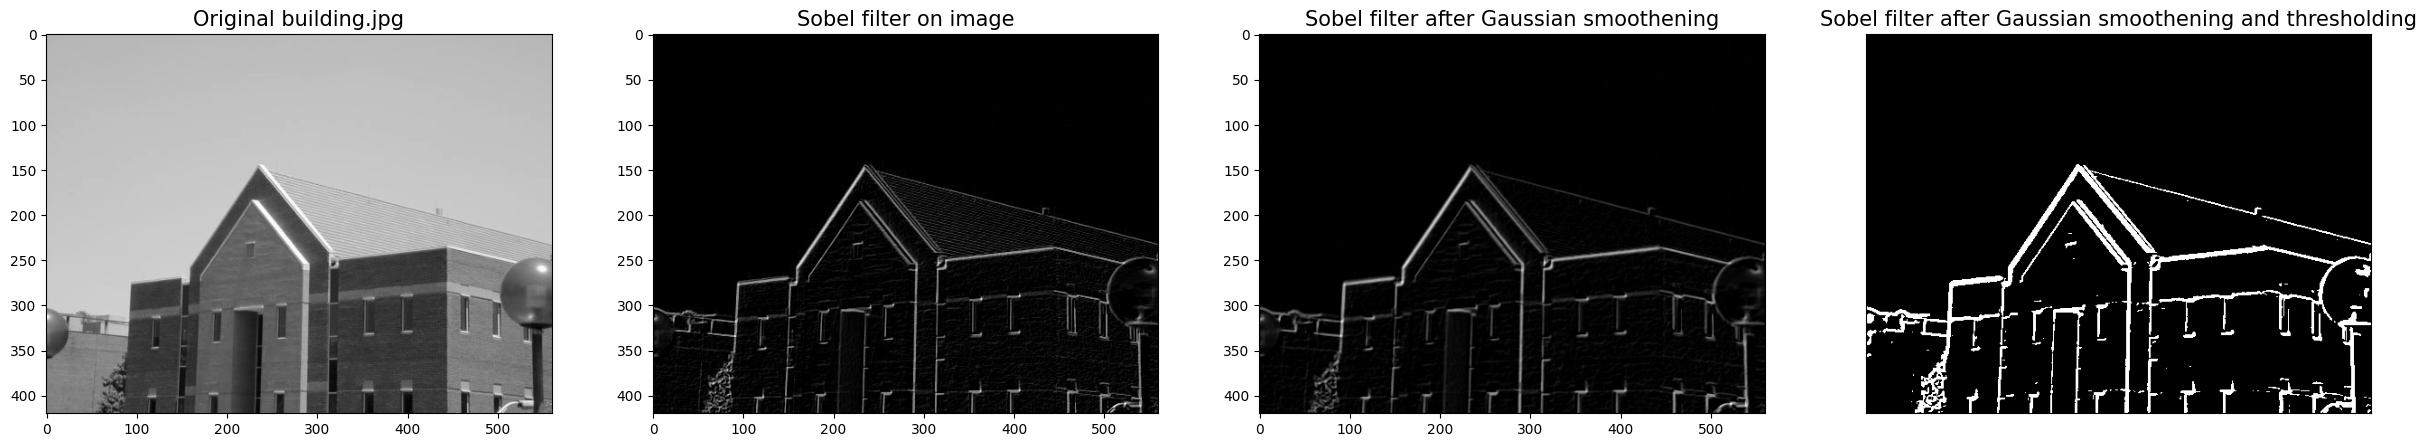

In [ ]:
img = cv2.imread('Assignment6/building.jpg', 0)
# Gaussian Smooothening
img_noise_rem = cv2.GaussianBlur(img, (3, 3), 1.5)

# Applying sobel filter
sob_img = app_sob(img)
sob_img_noise_rem = app_sob(img_noise_rem)
sob_img_threshold = app_threshold(sob_img_noise_rem)

fig, ax = plt.subplots(1,4,figsize=(30,6))
ax[0].imshow(img, cmap = 'gray')
ax[0].set_title('Original building.jpg', fontsize = 15), plt.xticks([]), plt.yticks([])
ax[1].imshow(sob_img, cmap = 'gray')
ax[1].set_title('Sobel filter on image', fontsize = 15), plt.xticks([]), plt.yticks([])
ax[2].imshow(sob_img_noise_rem, cmap = 'gray')
ax[2].set_title('Sobel filter after Gaussian smoothening', fontsize = 15), plt.xticks([]), plt.yticks([])
ax[3].imshow(sob_img_threshold, cmap = 'gray')
ax[3].set_title('Sobel filter after Gaussian smoothening and thresholding', fontsize = 15), plt.xticks([]), plt.yticks([])
plt.show()

### b) LoG (finding zero crossings)

In [ ]:
# Applying LoG filtering
def app_log(img):
  img_den = cv2.GaussianBlur(img, (3, 3), 1.5)
  return cv2.Laplacian(img_den, cv2.CV_64F)

# Applying zero-crossing
def zero_crossing(image):
  z_c_image = np.zeros(image.shape)

  '''
  For each pixel, count the number of positive
  and negative pixels in the neighborhood
  '''
  for i in range(1, image.shape[0] - 1):
    for j in range(1, image.shape[1] - 1):
      neg, pos = 0, 0
      neighbour = [image[i+1, j-1],image[i+1, j],image[i+1, j+1],image[i, j-1],image[i, j+1],image[i-1, j-1],image[i-1, j],image[i-1, j+1]]
      d, e = max(neighbour), min(neighbour)
      for h in neighbour:
        if h>0:
          pos += 1
        elif h<0:
          neg += 1

      '''
       If both negative and positive values exist in
       the pixel neighborhood, then that pixel is a
       potential zero crossing
      '''

      z_c = ((neg > 0) and (pos > 0))
      '''
       Change the pixel value with the maximum neighborhood
       difference with the pixel
      '''

      if z_c:
        if image[i,j]>0:
          z_c_image[i, j] = image[i,j] + np.abs(e)
        elif image[i,j]<0:
          z_c_image[i, j] = np.abs(image[i,j]) + d

  return z_c_image

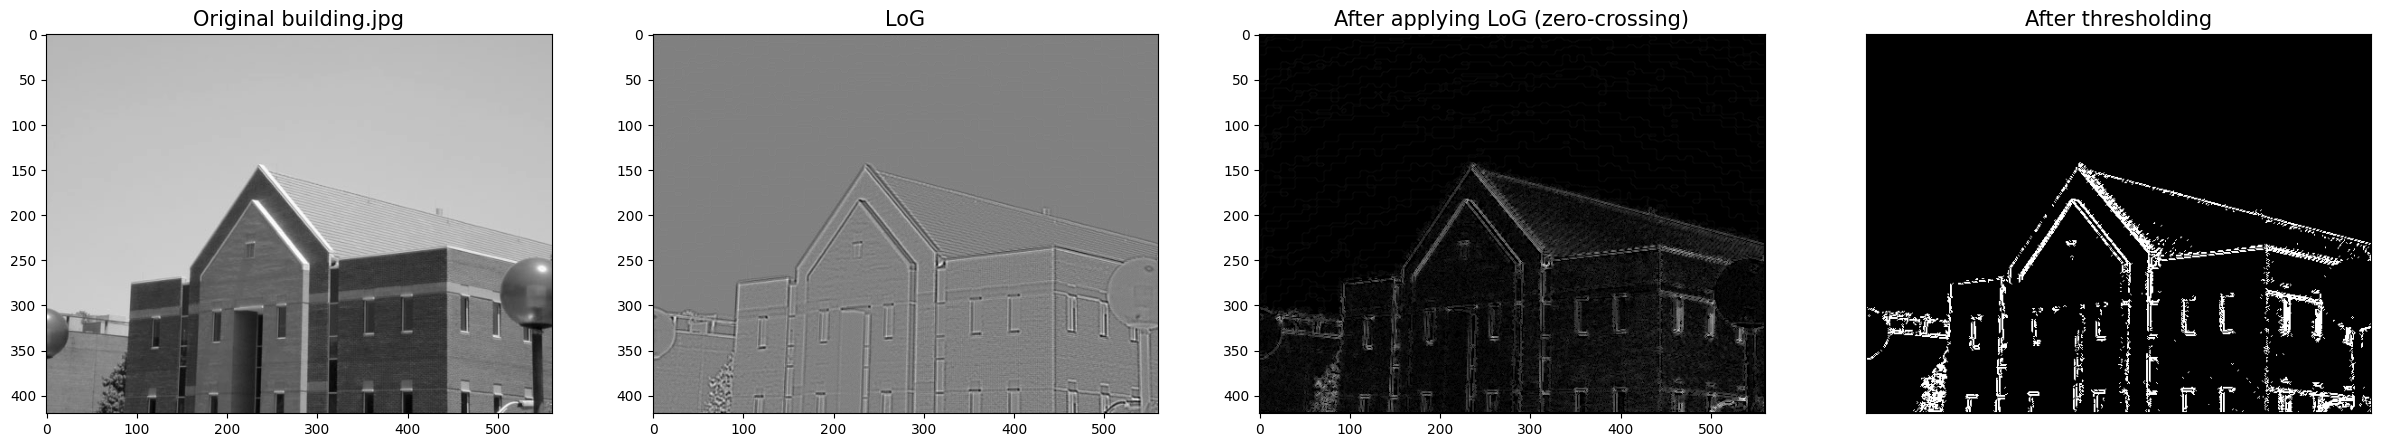

In [ ]:
log_img = app_log(img)
zc_log = zero_crossing(log_img)
zc_log_threshold = app_threshold(zc_log, threshold = 17)

fig, ax = plt.subplots(1,4,figsize=(30,6))
ax[0].imshow(img, cmap = 'gray')
ax[0].set_title('Original building.jpg', fontsize = 15), plt.xticks([]), plt.yticks([])
ax[1].imshow(log_img, cmap = 'gray')
ax[1].set_title('LoG', fontsize = 15), plt.xticks([]), plt.yticks([])
ax[2].imshow(zc_log, cmap = 'gray')
ax[2].set_title('After applying LoG (zero-crossing)', fontsize = 15), plt.xticks([]), plt.yticks([])
ax[3].imshow(zc_log_threshold, cmap = 'gray')
ax[3].set_title('After thresholding', fontsize = 15), plt.xticks([]), plt.yticks([])
plt.show()

### c) Canny edge detector

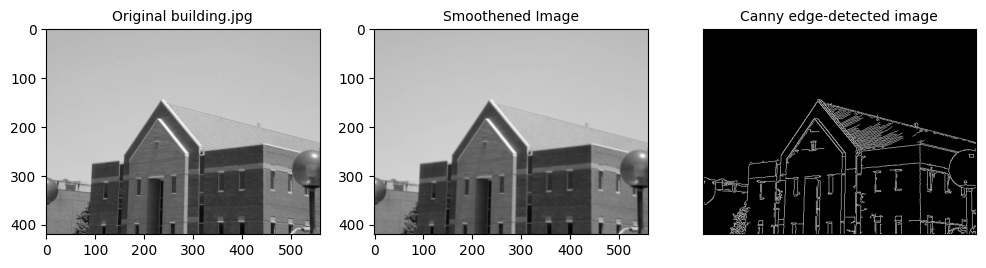

In [ ]:
smooth = cv2.GaussianBlur(img, (3,3), 1.5)
canny = cv2.Canny(img, 30, 150)

fig, ax = plt.subplots(1,3,figsize=(12,5))
ax[0].imshow(img, cmap = 'gray')
ax[0].set_title('Original building.jpg', fontsize = 10), plt.xticks([]), plt.yticks([])
ax[1].imshow(smooth, cmap = 'gray')
ax[1].set_title('Smoothened Image', fontsize = 10), plt.xticks([]), plt.yticks([])
ax[2].imshow(canny, cmap = 'gray')
ax[2].set_title('Canny edge-detected image', fontsize = 10), plt.xticks([]), plt.yticks([])
plt.show()

### d) Hough transform

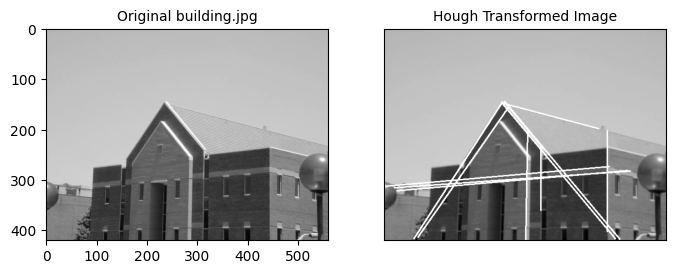

In [ ]:
hough_image = cv2.GaussianBlur(img, (3,3), 1.5)
edges = cv2.Canny(hough_image, 50, 200, apertureSize = 3)
lines = cv2.HoughLinesP(edges, 2, np.pi/180, threshold = 150, minLineLength=100,
                        maxLineGap=250)

for line in lines:
    x1, y1, x2, y2 = line[0]
    cv2.line(hough_image, (x1, y1), (x2, y2), (255, 0, 0), 2)

fig, ax = plt.subplots(1,2,figsize=(8,5))
ax[0].imshow(img, cmap = 'gray')
ax[0].set_title('Original building.jpg', fontsize = 10), plt.xticks([]), plt.yticks([])
ax[1].imshow(hough_image, cmap = 'gray')
ax[1].set_title('Hough Transformed Image', fontsize = 10), plt.xticks([]), plt.yticks([])
plt.show()

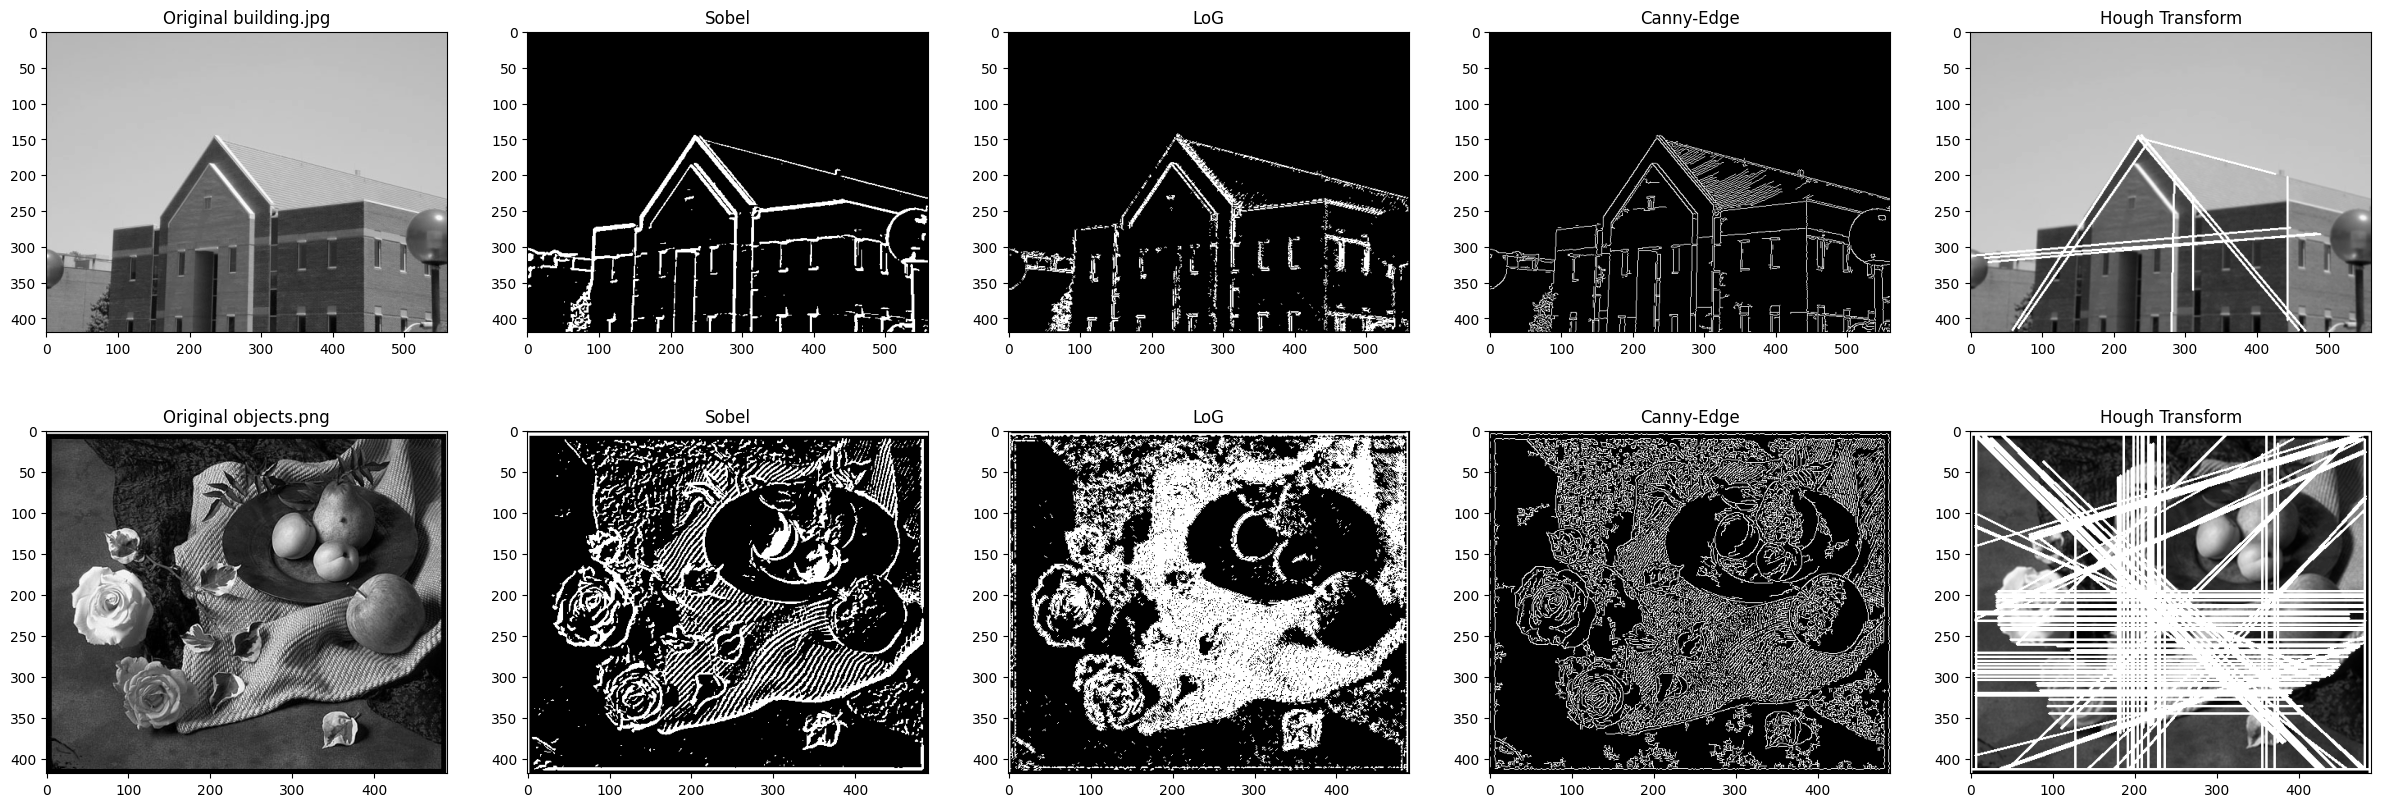

In [ ]:
img2 = cv2.imread('Assignment6/objects.png', 0)
# Gaussian Smooothening
img_noise_rem2 = cv2.GaussianBlur(img2, (3, 3), 1.5)

# Applying sobel filter
sob_img2 = app_sob(img2)
sob_img_noise_rem2 = app_sob(img_noise_rem2)
sob_img_threshold2 = app_threshold(sob_img_noise_rem2)

# Applying LoG
log_img2 = app_log(img2)
# Applying zero-crossing
zc_log2 = zero_crossing(log_img2)
# Applying thresholding
zc_log_threshold2 = app_threshold(zc_log2, threshold = 17)

# Canny edge detection
smooth2 = cv2.GaussianBlur(img2, (3,3), 1.5)
canny2 = cv2.Canny(img2, 30, 150)

# Hough Transform
hough_image2 = cv2.GaussianBlur(img2, (3,3), 1.5)
edges2 = cv2.Canny(hough_image2, 50, 200, apertureSize = 3)
lines2 = cv2.HoughLinesP(edges2, 2, np.pi/180, threshold = 150, minLineLength=100,
                        maxLineGap=250)

# Draw lines on the image
for line in lines2:
    x1, y1, x2, y2 = line[0]
    cv2.line(hough_image2, (x1, y1), (x2, y2), (255, 0, 0), 2)

fig, ax = plt.subplots(2,5,figsize=(30,10))
ax[0,0].imshow(img, cmap = 'gray')
ax[0,0].set_title('Original building.jpg', fontsize = 12)
ax[0,1].imshow(sob_img_threshold, cmap = 'gray')
ax[0,1].set_title('Sobel', fontsize = 12)
ax[0,2].imshow(zc_log_threshold, cmap = 'gray')
ax[0,2].set_title('LoG', fontsize = 12)
ax[0,3].imshow(canny, cmap = 'gray')
ax[0,3].set_title('Canny-Edge', fontsize = 12)
ax[0,4].imshow(hough_image, cmap = 'gray')
ax[0,4].set_title('Hough Transform', fontsize = 12)
ax[1,0].imshow(img2, cmap = 'gray')
ax[1,0].set_title('Original objects.png', fontsize = 12)
ax[1,1].imshow(sob_img_threshold2, cmap = 'gray')
ax[1,1].set_title('Sobel', fontsize = 12)
ax[1,2].imshow(zc_log_threshold2, cmap = 'gray')
ax[1,2].set_title('LoG', fontsize = 12)
ax[1,3].imshow(canny2, cmap = 'gray')
ax[1,3].set_title('Canny-Edge', fontsize = 12)
ax[1,4].imshow(hough_image2, cmap = 'gray')
ax[1,4].set_title('Hough Transform', fontsize = 12)
plt.show()

By visual comparison we immediately conclude that Canny Edge Detection works the best for building.jpg. From the above results we also observe that for building.jpg, Hough transform has been able to detect the lines since the image has very well-defined straight lines.

On the other hand, for the image objects.png, Hough transform fails terribly in edge-detection since the image contains mostly circular and curved objects with non-linear edges. For such an image we may implement the method described below (Hough transform for circular edge detection):

In [ ]:
# Hough transform to detect circular edges
circles = cv2.HoughCircles(img_noise_rem2, cv2.HOUGH_GRADIENT, 1, 20,
                            param1=50, param2=30, minRadius=10, maxRadius=25)
circles = np.uint16(np.around(circles))
for i in circles[0,:]:
  # draw the outer circle
  cv2.circle(img_noise_rem2, (i[0],i[1]), i[2], (0,255,0), 2)
  # draw the center of the circle
  cv2.circle(img_noise_rem2, (i[0],i[1]), 2, (0,0,255), 3)

fig, ax = plt.subplots(1,2,figsize=(10,5))
ax[0].imshow(img2, cmap = 'gray')
ax[0].set_title('Original objects.png', fontsize = 10), plt.xticks([]), plt.yticks([])
ax[1].imshow(img_noise_rem2, cmap = 'gray')
ax[1].set_title('Hough Circular Transform', fontsize = 10), plt.xticks([]), plt.yticks([])
plt.show()